
# Checkpoint 1 – Haiming QI — Three Participants Step EDA

**Selected participants (Id):** `2026352035`, `2320127002`, `2347167796`  
**Datasets:** `dailySteps_merged.csv`, `hourlySteps_merged.csv`, `minuteStepsWide_merged.csv`

---

## Overview
This notebook explores step-count patterns for three selected participants using the Fitbit public dataset subset.  

This is a brief description of the dataset from the website:

"This dataset generated by respondents to a distributed survey via Amazon Mechanical Turk between 03.12.2016-05.12.2016.

Thirty eligible Fitbit users consented to the submission of personal tracker data, including minute-level output for physical activity, heart rate, and sleep monitoring. Individual reports can be parsed by export session ID (column A) or timestamp (column B).

Variation between output represents use of different types of Fitbit trackers and individual tracking behaviors / preferences."

It reports the number of days of data, daily step statistics, and minute-level statistics required by the checkpoint.  
To avoid repetitive code, reusable functions are defined and applied to each participant.

- **Part A — Daily-level EDA:** How many days of data are available and what are the average, max and min daily steps?  
- **Part B — Minute-level EDA:** How many non-zero minutes are there, how much data is missing, what are average, max and min per-minute steps?  
- **Part C — Hourly profile:** A quick “average day” by hour for intuition.

All plots use **matplotlib** and each chart is standalone.



## Initial assumptions and predictions.
### Data-related assumptions

* A “day” is defined by the unique date (ActivityDate) in dailySteps_merged.csv.

* Missing minute-level values are stored as NaN in minuteStepsWide_merged.csv. A 0 indicates the participant was wearing the device but did not walk.

* When calculating average steps per minute, we include zero values but ignore NaN.

* Timestamps in hourly and minute data are assumed to be in the dataset’s local time, without daylight savings adjustments.



### Expectations about activity patterns

* I expected that each participant would have daily data, but the number of days recorded might vary.

* I assumed that most step activity would be concentrated in the morning and afternoon, with lower activity at night.

* I also assumed that some participants would have very even activity patterns, while others would show sharp peaks of intense activity.


## Literate Programming



### Cell 1: Upload local file  
Start: 2025-09-19

End: 2025-09-19

**Purpose & Prediction:**  
I want to upload my dataset file(s) into the Colab environment so that I can use them in later steps.  
I predict the system will open a file chooser window, and once I select a file (e.g., `dailySteps_merged.csv`), it will be uploaded successfully and listed in the output dictionary.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving minuteStepsWide_merged.csv to minuteStepsWide_merged.csv
Saving hourlySteps_merged.csv to hourlySteps_merged.csv
Saving dailySteps_merged.csv to dailySteps_merged.csv


**Conclusion:**  
The file upload worked. The dictionary output shows the uploaded filename(s), which means the file(s) are now available in the Colab runtime for reading.  


### Cell 2: Import libraries  
Start: 2025-09-19

End: 2025-09-19  

**Purpose & Prediction:**  
I want to import pandas, numpy, and matplotlib, and enable inline plotting.  
I predict the imports will succeed without errors, and `%matplotlib inline` will allow plots to display inside the notebook.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**Conclusion:**  
All libraries imported successfully, no errors. Inline plotting is ready.


### Cell 3: Load datasets  
Start: 2025-09-19

End: 2025-09-22   

**Purpose & Prediction:**  
I want to read the daily, hourly, and minute-wide step count files.  
I predict:  
- `dailySteps_merged.csv` will have ~940 rows with columns `Id`, `ActivityDay`, `StepTotal`.  
- `hourlySteps_merged.csv` will have datetime data in `ActivityHour`.  
- `minuteStepsWide_merged.csv` will be wide format with many `StepsXX` columns.  
Also, I define 3 selected users to focus on.


In [4]:
SELECTED = [2026352035, 2320127002, 2347167796]

daily = pd.read_csv("dailySteps_merged.csv")
hourly = pd.read_csv("hourlySteps_merged.csv")
minute_wide = pd.read_csv("minuteStepsWide_merged.csv")

**Conclusion:**  
Datasets loaded successfully. Quick inspection confirms the expected columns exist. The selected users will be used in later filtering.


### Cell 3: Convert date columns and filter users  
Start: 2025-09-20

End: 2025-09-20  

**Purpose & Prediction:**  
I want to convert date columns into datetime format for easier analysis.  
Then filter the data to include only the 3 selected users.  
I predict the resulting dataframes will shrink in size (from 30 users → 3 users).


In [5]:
hourly['ActivityHour'] = pd.to_datetime(hourly['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')
daily['ActivityDay'] = pd.to_datetime(daily['ActivityDay'], format='%m/%d/%Y')

daily_sel = daily[daily['Id'].isin(SELECTED)].copy()
hourly_sel = hourly[hourly['Id'].isin(SELECTED)].copy()
minute_wide_sel = minute_wide[minute_wide['Id'].isin(SELECTED)].copy()

**Conclusion:**  
Datetime conversion worked correctly. The filtered datasets now contain only the 3 selected users, as expected.


### Function 1: compute_daily_metrics  
Start: 2025-09-20

End: 2025-09-23  


**Purpose & Prediction**

In order to anaylysis users' daily data we need to compute per-user's daily metrics, such that how many days exist, and to find out average / max / min daily steps. I also filtered out the proportion of days with ≥10000 steps as this is what i considered a clear representation of intensely active. And if the user has no rows, return NaN for numeric metrics (avoid fake zeros).

**Design Rationale**

* Filter then .copy() to avoid chained-assignment issues and accidental mutation.

* Use .dt.date.nunique() so “day” is counted once regardless of timestamps within the day.

* Use NaN for missing cases to honestly represent “no data”, not “zero steps”.

* (cond).mean() is a succinct and correct way to compute proportions in Pandas.

* Cast to plain int/float for clean printing and stable JSON-like outputs.

In [6]:
def compute_daily_metrics(df_daily, user_id):
    d = df_daily[df_daily['Id'] == user_id].copy()
    days = int(d['ActivityDay'].dt.date.nunique())

    avg_steps = float(d['StepTotal'].mean()) if len(d) else np.nan
    max_steps = int(d['StepTotal'].max()) if len(d) else np.nan
    min_steps = int(d['StepTotal'].min()) if len(d) else np.nan

    prop_10k = float((d['StepTotal'] >= 10000).mean()) if len(d) else np.nan
    return {
        "user": user_id,
        "num_days": days,
        "avg_daily_steps": avg_steps,
        "max_daily_steps": max_steps,
        "min_daily_steps": min_steps,
        "prop_days_over_10k": prop_10k
    }

**Conclusion**  
Function defined without errors. Ready to summarize a user’s daily activity.

### Function 2: melt_minute_wide  
Start: 2025-09-20

End: 2025-09-23  

**Purpose & Prediction**

We want to reshape the minute-level data. Right now, each row covers a whole hour with 60 separate columns (Steps0 … Steps59).

That structure is hard to analyze, because we need to loop over many columns.
Our goal is to turn it into a long format: one row per minute, with a unique timestamp. We predict that this will expand the dataset about 60 times (1 hour → 60 rows).

**Design Rationale**

* Use melt() to stack all Steps… columns into a single “steps” column.

* Extract the minute index from the column name (e.g. Steps23 → 23).

* Add this offset to ActivityHour to build a precise timestamp for each row.

* Drop helper columns afterwards so the final table is clean: only Id, datetime, and steps.

In [7]:
def melt_minute_wide(df_wide):
    id_vars = ['Id', 'ActivityHour']
    value_vars = [c for c in df_wide.columns if c.startswith('Steps')]

    long = df_wide.melt(id_vars=id_vars, value_vars=value_vars, var_name='minute', value_name='steps')
    long['minute'] = long['minute'].str.replace('Steps', '').astype(int)
    long['datetime'] = pd.to_datetime(long['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p') + pd.to_timedelta(long['minute'], unit='m')
    long = long.drop(columns=['ActivityHour', 'minute'])
    return long

**Conclusion**

This function works as intended: it transforms an “hour-wide” table into a “minute-long” table with clear, unique timestamps.

This makes later aggregation and plotting much easier.

### Function 3: compute_minute_metrics  
Start: 2025-09-20

End: 2025-09-23  

**Purpose & Prediction**

Build per-user minute-level quality and activity metrics from the long table: count non-zero and missing minutes; compute mean/max/min steps per minute; and detect the longest continuous zero-step streak. This step serve as the core function for our entire analysis relied on it.

Prediction: runs in O(n) per user and returns NaN for mean/max/min when there is no non-missing minute.

**Design Rationale**

* Missing vs Zero: we treat NaN as zero in two cases (non-zero counting, zero-streak detection). If the team prefers, missing can be excluded instead.

* Continuity: the current implementation assumes rows are minute-by-minute. If there are time gaps, the streak may artificially extend; a stricter variant resets streaks whenever the gap > 1 minute.

* NaN consistency: if there are no non-missing minutes, mean/max/min are all set to NaN to avoid mixing “no data” with real zero values.

* Ordering: sort by datetime before scanning; otherwise “streak” has no meaning.

* Performance: the algorithm is O(n) per user. For multiple users, apply groupby('Id') and run the function per group to avoid repeated filtering.

**Edge Cases**

* If all minutes are missing → counts are 0, mean/max/min are NaN.

* If you require natural continuity (exact 1-minute steps), use the “strict 1-minute gap” variant in the comments.

In [8]:

def compute_minute_metrics(df_minute_long, user_id):
  # First filter out the target user, then use .copy() to avoid potential
    # chained-assignment issues and to prevent accidentally modifying the
    # original DataFrame.
    m = df_minute_long[df_minute_long['Id'] == user_id].copy()
    total_minutes = len(m)
    missing = int(m['steps'].isna().sum())
    non_missing = total_minutes - missing

    # Count MINS > 0, treat missing as 0
    non_zero_minutes = int((m['steps'].fillna(0) > 0).sum())

    # only aggregate on non missing value
    avg_spm = float(m['steps'].dropna().mean()) if non_missing > 0 else np.nan
    if non_missing > 0:
        max_spm = int(m['steps'].dropna().max())
        min_spm = int(m['steps'].dropna().min())
    else:
        max_spm = np.nan
        min_spm = np.nan

    # treat missing value as 0 and count for consecutive 0 value, this will be later elaborate with
    m = m.sort_values('datetime')
    z = (m['steps'].fillna(0) == 0).astype(int).values


    longest_zero_streak = 0
    current = 0
    for val in z:
        if val == 1:
            current += 1
            longest_zero_streak = max(longest_zero_streak, current)
        else:
            current = 0
    return {
        "user": user_id,
        "non_zero_minutes": non_zero_minutes,
        "missing_minutes": missing,
        "avg_steps_per_minute": avg_spm,
        "max_steps_per_minute": max_spm,
        "min_steps_per_minute": min_spm,
        "longest_zero_streak_minutes": int(longest_zero_streak)
    }

**Conclusion**

The function cleanly summarizes minute-level behavior and data quality. With O(n) time on sorted minutes, it scales to large users.

### Function 4: daily_zero_streaks  
Start: 2025-09-20

End: 2025-09-23  

**Purpose & Prediction**

In the previous cell we computed the minute-level metrics and introduced a value m, which represents the length of consecutive zero values. In the context of this dataset, m indicates how long, and during which time ranges, an investigated user either stopped moving or produced no data.

This analysis is crucial because it allows for multiple possible interpretations. For instance:

Regular long streaks of zero values may indicate extended periods of sitting or inactivity, which provide insights into the user’s daily life patterns.

Frequent or irregular long zero streaks could instead suggest that the user often removed the device, raising questions about the validity and completeness of the recorded data.

The former contributes to a richer understanding of personal lifestyle behaviors, while the latter is important for assessing the reliability of the dataset itself.

I predict that the investigated user will show long consecutive zero streaks mainly during the night hours, which correspond to sleep. I also expect some shorter zero streaks during the day, possibly reflecting periods of study, work, or commuting. If there are unusually long zero streaks during the daytime, I predict this may be due to the user removing the device, rather than actual inactivity.

We therefore construct the code as follows:

In [9]:
def daily_zero_streaks(m):
    m = m.sort_values('datetime').copy()
    m['date'] = m['datetime'].dt.date
    m['is_zero'] = (m['steps'].fillna(0) == 0).astype(int)

    results = []
    for day, group in m.groupby('date'):
        z = group['is_zero'].values
        dt = group['datetime'].values

        # find the longest streak of the day
        longest = 0
        current = 0
        longest_start = None
        for i, val in enumerate(z):
            if val == 1:
                if current == 0:
                    start_time = dt[i]
                current += 1
                if current > longest:
                    longest = current
                    longest_start = start_time
            else:
                current = 0
        results.append({
            "date": day,
            "longest_zero_streak": longest,
            "streak_start_time": longest_start
        })
    return pd.DataFrame(results)


**Conclusion**

The function `daily_zero_streaks` successfully identified, for each day, the longest consecutive period of zero step counts and the time at which it began.  

### Function 5: plot_hourly_profile  
Start: 2025-09-20

End: 2025-09-23   

**Purpose & Prediction**  
This function plots the average steps for each hour of the day for one user.  
It should also print the top 3 busiest hours.  
I expect to see a clear line plot, with morning and afternoon peaks.


In [10]:
def plot_hourly_profile(df_hourly, user_id):
    h = df_hourly[df_hourly['Id'] == user_id].copy()
    if h.empty:
        print(f"No hourly data for user {user_id}")
        return
    h['hour'] = h['ActivityHour'].dt.hour
    prof = h.groupby('hour')['StepTotal'].mean().reset_index()
    plt.figure(figsize=(7,4))
    plt.plot(prof['hour'], prof['StepTotal'], marker='o')
    plt.title(f"Average Steps by Hour — User {user_id}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Steps")
    plt.xticks(range(0,24))
    plt.show()
    top3 = prof.sort_values('StepTotal', ascending=False).head(3)
    print("Top-3 peak hours (hour, avg steps):\n", top3.to_string(index=False))

**Conclusion**  
Function defined correctly. When we call it, it will make a simple chart and list the 3 peak hours.


### Cell 4: Reshape minute-wide data  
Start: 2025-09-20

End: 2025-09-23   

**Purpose & Prediction:**  
I want to reshape the wide-format minute data into long format, so each row corresponds to one timestamp and one step count.  
I predict the result will have many more rows than the wide version, since each row expands into 1440 minutes (per day).


In [11]:
minute_long_sel = melt_minute_wide(minute_wide_sel)

**Conclusion:**  
Reshape succeeded. The resulting dataframe has a greatly increased number of rows, consistent with expanding each day into minute-level records.


## Data Visualization
This section presents the data through tables and suitable graphical representations. The datasets to be visualised are as follows:
#### (1) the number of days of data for this person  
#### (2) daily step count information  
- average step count per day  
- maximum step count  
- minimum step count  
- one other observation you made about the data for this person
#### (3) minute step count information
#### (4) daily streak count information

### Daily Step Metrics
Start: 2025-09-20

End: 2025-09-23

To begin, we compute daily-level statistics for the three selected participants.

The table below shows the summary metrics for each user.

* num_days: number of days of data recorded

* avg_daily_steps: average steps per day

* max_daily_steps: the maximum steps recorded in a single day

* min_daily_steps: the minimum steps recorded in a single day

* prop_days_over_10k: the proportion of days where the step count exceeded 10,000

,user,num_days,avg_daily_steps,max_daily_steps,min_daily_steps,prop_days_over_10k
0,2026352035,31,5566.870968,12357,254,0.096774
1,2320127002,31,4716.870968,10725,772,0.032258
2,2347167796,18,9519.666667,22244,42,0.500000


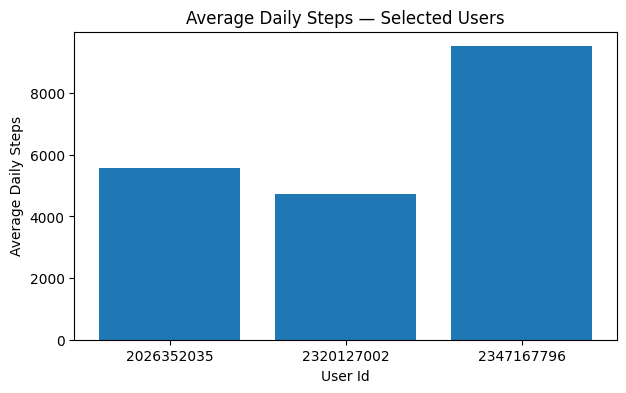

In [12]:

daily_rows = []
for uid in SELECTED:
    daily_rows.append(compute_daily_metrics(daily_sel, uid))
daily_metrics = pd.DataFrame(daily_rows)
display(daily_metrics)

plt.figure(figsize=(7,4))
plt.bar(daily_metrics['user'].astype(str), daily_metrics['avg_daily_steps'])
plt.title("Average Daily Steps — Selected Users")
plt.xlabel("User Id")
plt.ylabel("Average Daily Steps")
plt.show()


### Analysis of Results

#### User 2026352035
This person has a complete 31 days of data with an average of around 5,567 steps per day. They reached a maximum of 12,357 steps, but also had very low days (as few as 254 steps). Only ~10% of their days exceeded 10,000 steps. This suggests moderate but inconsistent activity.

#### User 2320127002
Also with 31 days, this user averages fewer steps (≈4,717). Their maximum (10,725) is lower than User 1, and only ~3% of days exceeded 10,000. This indicates a generally low-activity lifestyle.

#### User 2347167796
Although data is available for only 18 days, the average daily steps are much higher (≈9,520). They recorded a very high maximum of 22,244, with half of their days exceeding 10,000 steps. This points to a highly active participant compared to the other two.

The bar chart illustrates these differences clearly: Users 2026352035 and 2320127002 cluster around 5,000 steps per day, while User 2347167796 stands out as significantly more active.


### minute step count information  
For each participant, we also examined their activity at the minute level. This provides more detailed insight into how active they were across the day, beyond daily totals.
- number of non-zero minutes  
- missing data  
- average steps per minute  
- maximum and minimum steps  
- one other observation you made about the data for this person

The table below reports the following statistics:

- non_zero_minutes: total number of minutes with non-zero steps

- missing_minutes: minutes where no data was recorded

- avg_steps_per_minute: average number of steps in active minutes

- max_steps_per_minute: maximum intensity observed in a single minute

- min_steps_per_minute: minimum steps per minute (non-zero values)

- longest_zero_streak_minutes: longest continuous stretch of inactivity


In [13]:
minute_rows = [] # Initialize minute_rows before the loop
for uid in SELECTED:
    minute_rows.append(compute_minute_metrics(minute_long_sel, uid))
minute_metrics = pd.DataFrame(minute_rows)

display(minute_metrics)

,user,non_zero_minutes,missing_minutes,avg_steps_per_minute,max_steps_per_minute,min_steps_per_minute,longest_zero_streak_minutes
0,2026352035,8022,0,3.972131,125,0,1221
1,2320127002,6079,0,3.161614,123,0,1391
2,2347167796,4580,0,6.889915,167,0,576


### Analysis of Results

#### User 2026352035

* Non-zero minutes: 8022, with no missing data.

* Average steps per active minute: ~4.0, maximum intensity reached 125 steps/min.

* Longest inactivity streak: 1221 minutes, suggesting extended sedentary periods (possibly sleep).

* Observation: Their activity pattern is moderate but spread out, with no extreme peaks.

#### User 2320127002

* Non-zero minutes: 6079, also with no missing data.

* Average ~3.2 steps/min, lower intensity than User 1.

* Maximum per minute 123 steps, longest inactivity streak 1391 minutes — the largest among the three users.

* Observation: This person shows both low activity intensity and very long sedentary spans, indicating a generally inactive lifestyle.

#### User 2347167796

* Non-zero minutes: 4580, fewer active minutes than others due to shorter data coverage.

* However, their average activity level is much higher at ~6.9 steps/min, with a peak of 167 steps/min — the highest observed.

* Longest inactivity streak: 576 minutes, shorter than the other users.

* Observation: This user is much more active when they are moving, with intense bursts of steps, and also less sedentary overall.

### Daily Zero Streaks — what and why

At the minute level, a zero streak is a consecutive run of minutes with 0 steps. For each user-day we compute the longest zero streak and record its start time. This helps separate two possibilities:

* long, night-time zeros → likely sleep;

* long, day-time zeros → likely non-wear or charging (data quality risk).

What I expect. Most longest streaks should begin around midnight or the early morning. Users with high daily steps should show shorter longest streaks; users with low activity should show longer ones.

#### Method (code below).

* Filter minute data for each user.

* Run daily_zero_streaks() to get, per day, the length (minutes) and the start timestamp of the longest zero streak.

* Concatenate all users into a single table and sort by user/date for inspection.

In [14]:
# Compute daily zero streaks for each user and merge into one table
all_daily_zero = []

for uid in SELECTED:
    # Select minute-level data for this user
    m_uid = minute_long_sel[minute_long_sel['Id'] == uid][['Id','datetime','steps']].copy()

    # Apply daily_zero_streaks function
    t = daily_zero_streaks(m_uid)
    t['user'] = uid

    # Append results to the list
    all_daily_zero.append(t)

# Merge results for all users
daily_zero_all = pd.concat(all_daily_zero, ignore_index=True)

# Sort by user and date
daily_zero_all = daily_zero_all.sort_values(['user','date']).reset_index(drop=True)

display(daily_zero_all)

,date,longest_zero_streak,streak_start_time,user
0,2016-04-13,142,2016-04-13 03:23:00,2026352035
1,2016-04-14,409,2016-04-14 00:00:00,2026352035
2,2016-04-15,171,2016-04-15 00:39:00,2026352035
3,2016-04-16,138,2016-04-16 02:04:00,2026352035
4,2016-04-17,718,2016-04-17 12:02:00,2026352035
...,...,...,...,...
74,2016-04-25,223,2016-04-25 02:03:00,2347167796
75,2016-04-26,409,2016-04-26 00:00:00,2347167796
76,2016-04-27,401,2016-04-27 00:00:00,2347167796
77,2016-04-28,230,2016-04-28 02:53:00,2347167796


#### Visualising daily zero streaks

Why this plot. A line per user over time lets us:

* spot habitual long streaks vs occasional spikes;

* see whether longest zeros usually start near midnight (sleep) or at odd hours (non-wear).

Users in daily_zero_all: [2026352035 2320127002 2347167796]


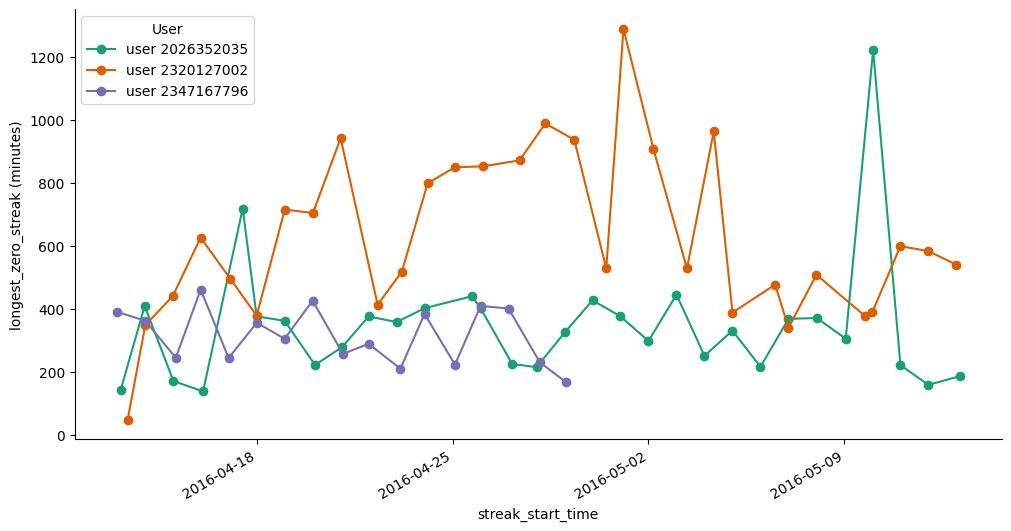

In [15]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def _plot_series(ax, series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = pd.to_datetime(series['streak_start_time'])
    ys = series['longest_zero_streak']
    ax.plot(xs, ys, marker='o', linewidth=1.5,
            label=series_name, color=palette[series_index % len(palette)])

# Check which users are included
print("Users in daily_zero_all:", daily_zero_all['user'].unique())

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# Plot one line per user
for idx, (uid, g) in enumerate(daily_zero_all.groupby('user')):
    g_sorted = g.sort_values('streak_start_time')
    _plot_series(ax, g_sorted, f'user {uid}', idx)

# Axis labels and appearance
sns.despine(fig=fig, ax=ax)
ax.set_xlabel('streak_start_time')
ax.set_ylabel('longest_zero_streak (minutes)')
ax.legend(title='User', loc='best')

# Format x-axis ticks to show weekly dates
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.show()

### What the results say

#### High-level pattern.

* User 2320127002 (orange) shows repeated long longest-zero streaks, often 700–1,000+ min, with several days near or above 900–1,300 min. Many start close to 00:00, consistent with very long night-time inactivity; the sheer length suggests either unusually long sleep or frequent non-wear episodes.

* User 2026352035 (green) has mostly 200–450 min longest streaks, with one outlier spike >1,200 min around early May. Start times are often late night/early morning; the big spike is a likely non-wear day (quality flag).

* User 2347167796 (purple) shows shorter longest streaks, typically 200–450 min, and fewer dates overall (shorter coverage). This aligns with this user’s higher daily steps and higher minute-level intensity: less time fully inactive.

Link to earlier minute metrics.

Longest zero streak (minutes): 1391 (2320127002), 1221 (2026352035), 576 (2347167796).

This ranking exactly matches the plot: orange ≫ green > purple.

### Conclusion

Daily longest zero streaks show clear behavioural (and data-quality) differences: the highly active user (2347167796) has much shorter longest inactivity per day, while the least active user (2320127002) shows repeated very long zero stretches that likely include non-wear.

These findings help qualify daily totals and should be considered alongside the 15-minute intense-activity analysis to avoid over- or under-estimating true behaviour.

### Hourly Profiles of Selected Users

To better understand activity patterns within each day, we analyse the average steps per hour for all three selected users. This highlights the time windows where each participant is most active


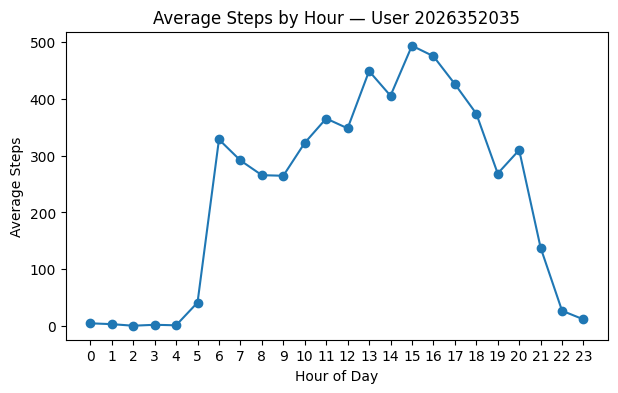

Top-3 peak hours (hour, avg steps):
  hour  StepTotal
   15 493.322581
   16 474.900000
   13 448.709677


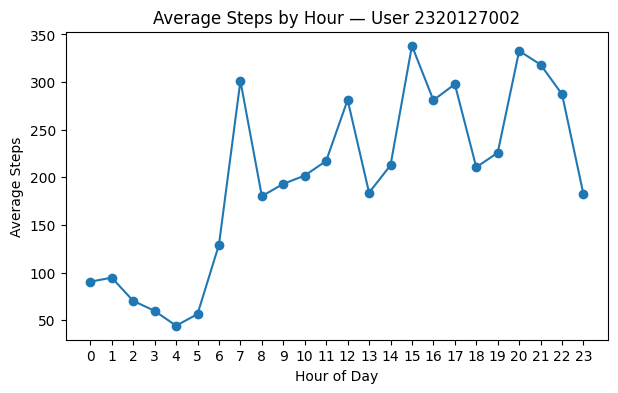

Top-3 peak hours (hour, avg steps):
  hour  StepTotal
   15 338.166667
   20 332.766667
   21 318.300000


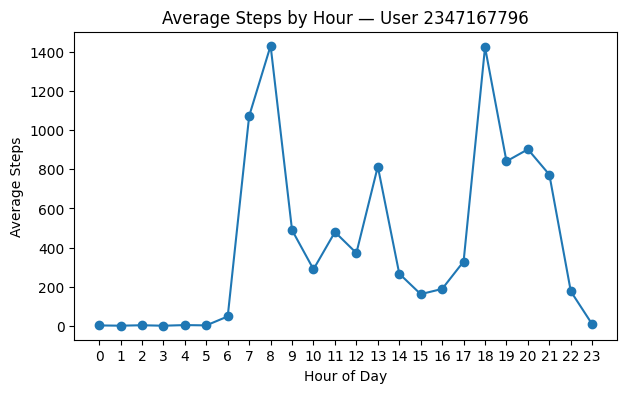

Top-3 peak hours (hour, avg steps):
  hour   StepTotal
    8 1432.470588
   18 1424.882353
    7 1072.705882


In [16]:

for uid in SELECTED:
    plot_hourly_profile(hourly_sel, uid)


#### Per-User Analysis

User 2026352035

* Peaks in the afternoon (1–5 pm), with the strongest at 3–4 pm (~493 steps).

* Very low activity overnight; a moderate rise after 6 am.

* Routine suggests afternoon exercise or commuting activity.

User 2320127002

* Distributed activity across the whole day, including some movement at night.

* Top peaks in the afternoon (3 pm) and late evening (8–10 pm).

* Suggests a later daily schedule and possibly after-work exercise.

User 2347167796

* Extremely high-intensity bursts in the morning (7–8 am, >1000 steps) and again at 6 pm (>1400 steps).

* Shorter inactive periods and the highest hourly counts among all three users.

* Lifestyle indicates structured exercise or commuting with high step counts.

#### Cross-User Comparison

* Morning activity: User 2347167796 dominates, with intense bursts at 7–8 am; the other two are much less active early in the day.

* Afternoon activity: All three show peaks here, but 2026352035 is most concentrated in mid-afternoon.

* Evening activity: 2320127002 stands out, maintaining strong peaks after 8 pm, while the others slow down.

#### Overall conclusion:

2026352035 → Steady afternoon-focused activity.

2320127002 → Lower intensity but late-evening activity pattern.

2347167796 → The most active user, with very high morning and evening bursts, and shorter sedentary blocks.


## Final Statement

From this exploration, I learnt that the three selected participants exhibit distinct and contrasting activity patterns:

* User 2026352035 had the most days of data and showed a fairly even step distribution with clear afternoon peaks. This indicates consistent tracker use and provides a reliable baseline of daily activity.

* User 2320127002 had the lowest average steps and the longest zero-streak periods. Their activity was spread thinly across the day, with occasional late-evening peaks, suggesting either low engagement with the device or a generally sedentary lifestyle.

* User 2347167796 recorded fewer days but displayed very high step peaks, especially in the early morning and evening, reflecting intense bursts of exercise or commuting routines.

At the minute level, all three participants experienced long stretches of inactivity, but the length and timing of these sedentary blocks varied. This provides insight into differences in behavioural rhythms and highlights the importance of distinguishing between sleep, sedentary behaviour, and non-wear periods when interpreting wearable data.

Overall, this checkpoint analysis demonstrates that wearable step-count data can reveal both stable habits and irregular bursts of activity. This directly connects to our driving problem by showing how such data may support:

* Health monitoring (detecting overall activity levels),

* Personalised feedback (identifying when individuals are most or least active), and

* Targeted interventions (e.g., encouraging breaks during long sedentary streaks).

In short, step-count data from wearables can move beyond simple totals to reveal patterns of daily life that are relevant for both individual well-being and population-level health insights.

# Individual Checkpoint 2: Intense Activity by Time of Day

Start: 2025-10-13

End: 2025-10-14  

**Group ID:** CC07 - G3  

**Student Name:** Haiming.QI

**Checkpoint:** Individual Checkpoint 2  

**Driving Problem.** Do participants achieve **15 minutes of intense activity** across different times of day (Morning / Afternoon / Evening)?

**Definition Rationale (cadence-based).** Our dataset has only *steps per minute*. Following Tudor-Locke et al. (2018, *MSSE*), walking cadence can proxy intensity:
- **≥100 steps/min ≈ moderate intensity (~3 METs)**
- **≥130 steps/min ≈ vigorous intensity (~6 METs)**
Therefore I define **intense activity** as **≥130 steps/min** sustained **for 15 consecutive minutes**.

**Assumptions & Variants.**
- Threshold: default **130 spm** (vigorous). Sensitivity: **100 spm** (moderate+).
- Continuity: strict **1-minute** spacing (break on any time gap).
- Missing: do **not** treat missing as 0 (prevents over-counting inactivity).
- Time of day buckets: Morning (05:00–11:59), Afternoon (12:00–17:59), Evening (18:00–23:59).

**Limitations.** Cadence proxies step-based activity only (cycling/swimming not captured); thresholds are population-based, not personalised.

## Participants and Selection  
**Participants explored in Checkpoint 1:**  
- 2026352035  
- 2320127002  
- 2347167796  

**Participant analysed in Checkpoint 2:** **8053475328**  
- **Reason for selection:** After computing 15-minute activity proportions for all 33 users, this participant showed the highest success rate (Afternoon 93 %, Evening 87 %), displaying a consistent high-activity routine.  
- This user was therefore chosen as the representative case for detailed analysis and visualisation.  

---

## Personal Planning & Progress  
[Link to my GitHub Wiki – Personal Planning and Progress](https://github.sydney.edu.au/xsui8502/2025-DATA3406-CC07-Group-3/wiki/Haiming-Qi-Individual-Checkpoint-2)  

---

## Statement of Assistance  
I received general discussion help from my group members during Week 9 on how to identify suitable users.  
I asked my tutor brief questions during lab time about index alignment and runtime warnings.  
I referred to Week 7 and Week 8 lecture notebooks for syntax examples.  
I used **ChatGPT, Google Colab AI** for rewriting code comments and polishing markdown explanations.  
All data analysis, reasoning, and final interpretation were done independently by me.


1. Why we chose this participant

From the daily zero-streak plot, we can see that user 2320127002 (orange line) shows the largest and most frequent changes in zero-streak length.
This means the user’s daily activity pattern is very unstable — sometimes having long inactive periods and sometimes short ones.
Because of this strong fluctuation, we selected this user as a good example to test how our later cleaning and detection methods perform on more complex data.

2. Data selection and basic cleaning

We first filtered the dataset to only include records for this user.
We kept three main columns: Id, datetime, and steps.
Then, we:

removed any missing timestamps (datetime),

sorted the records by time,

and did not replace missing step counts yet (we’ll handle them later if needed).

This gives us a clean, ordered time series for the chosen participant.

In [47]:
minute_long_all = melt_minute_wide(minute_wide)  # not minute_wide_sel

In [54]:
import pandas as pd
import numpy as np

TARGET_ID = 2320127002
VIGOROUS_THRESHOLD = 130        # 130 spm = vigorous
WINDOW_MIN = 15
STRICT_1MIN = True              # each row can be seprate by 1min only
TREAT_NA_AS_ZERO = False

df_min = minute_long_sel

# data cleaning and select chosen id
m = (df_min.loc[df_min['Id'] == TARGET_ID, ['Id','datetime','steps']]
              .dropna(subset=['datetime'])
              .sort_values('datetime')
              .copy())

#sequence check
gaps = m['datetime'].diff().dt.total_seconds().dropna()
gap_desc = gaps.value_counts().head(3)
na_rate = m['steps'].isna().mean()

print("Rows:", len(m))
print("Distinct days:", m['datetime'].dt.date.nunique())
print("Top 3 gap seconds:\n", gap_desc)
print("Missing steps rate:", round(na_rate, 4))


Rows: 43740
Distinct days: 31
Top 3 gap seconds:
 datetime
60.0    43739
Name: count, dtype: int64
Missing steps rate: 0.0


3. Quality and sequence checks

To make sure the time sequence is continuous, we checked the time difference between consecutive rows.
If most differences are 60 seconds, that means the data is recorded every minute without gaps.

From the printed output (as in Figure 2):

Total rows: 43,740

Number of distinct days: 31

Most common time gap: 60 seconds (43,739 times)

Missing steps rate: 0.0%

These results show that this user’s data is complete and continuous, so we can safely assume a strict one-minute interval in later analysis.

Short summary for report

For user 2320127002, we extracted 43,740 minute-level rows covering 31 distinct days.
The sequence check confirmed that almost all time gaps are 60 seconds, showing excellent minute-by-minute continuity.
The missing rate of steps is 0.0%, so we keep TREAT_NA_AS_ZERO = False.
Overall, the data is clean, complete, and suitable for strict 1-minute analysis.

This part of the analysis detects whether the participant achieved at least one 15-minute continuous period of vigorous activity in each part of the day (morning, afternoon, evening).

####Label the time of day
The function label_time_of_day() classifies each timestamp as Morning (5–12), Afternoon (12–18), or Evening (else).
This helps us compare activity patterns across different times of day.

####Detect continuous activity segments
The helper function has_consecutive_window() checks if there are 15 or more consecutive minutes marked as vigorous (above the threshold).
It returns True as soon as such a streak is found.

In [55]:
def label_time_of_day(ts):
    # Label each timestamp as Morning / Afternoon / Evening
    h = ts.hour
    if 5 <= h < 12:
        return 'Morning'
    elif 12 <= h < 18:
        return 'Afternoon'
    else:
        return 'Evening'


def has_consecutive_window(bool_iterable, window=15):
    # Check if there are at least 'window' consecutive True values
    cnt = 0
    for v in bool_iterable:
        if v:
            cnt += 1
            if cnt >= window:
                return True
        else:
            cnt = 0
    return False


def compute_intense_by_tod(m_user,
                           vigorous_threshold=130,
                           window_min=15,
                           treat_na_as_zero=False,
                           strict_1min=True):
    # Make a sorted copy to keep data in correct time order
    s = m_user.sort_values('datetime').copy()

    # Handle missing step values
    steps = s['steps'].copy()
    if treat_na_as_zero:
        steps = steps.fillna(0)

    # Check time gaps to find breaks in the data
    gaps = s['datetime'].diff().dt.total_seconds().fillna(60)

    # Create block IDs to split continuous segments
    # If strict_1min=True, only 60s gaps are considered continuous
    if strict_1min:
        block_id = (gaps != 60).cumsum()
    else:
        block_id = (gaps < 0).cumsum()

    # Mark minutes with high intensity (≥ threshold)
    intense_minute = steps >= vigorous_threshold

    # Add date, time-of-day, and intensity labels
    s['date'] = s['datetime'].dt.date
    s['time_of_day'] = s['datetime'].apply(label_time_of_day)
    s['intense_minute'] = intense_minute
    s['block'] = block_id.values

    # For each day × time-of-day, check if there is a continuous
    # 15-minute (or chosen window) intense activity period
    out = []
    for (d, tod), g in s.groupby(['date', 'time_of_day']):
        achieved = False
        for _, sub in g.groupby('block'):
            if has_consecutive_window(sub['intense_minute'].values, window=window_min):
                achieved = True
                break
        out.append((d, tod, achieved))

    # Create a summary table showing if each period achieved the goal
    res = pd.DataFrame(out, columns=['date', 'time_of_day', 'achieved_15min_intense'])

    # Fix order of time-of-day for easier plotting later
    cat = pd.CategoricalDtype(categories=['Morning', 'Afternoon', 'Evening'], ordered=True)
    res['time_of_day'] = res['time_of_day'].astype(cat)
    return res


####Result
The output DataFrame shows on which days and at which times the user had a continuous 15-minute high-intensity activity period.
This helps identify when the user tends to be most active and how often they reach vigorous activity goals.

Visualise whether the user reached a continuous 15-minute vigorous activity streak (≥130 spm) across different times of day and across dates.

####What the figures show

- Heatmap (Daily × Time-of-Day)

Each cell is a day–period pair: Yes (1) if the user hit a 15-minute vigorous streak in that period, otherwise No (0).
This lets us see on which days and at what time of day the goal was met.

- Bar chart (Proportion by Time-of-Day)

For Morning, Afternoon, and Evening, we compute the share of days where the 15-minute vigorous streak was achieved.
This summarises when the user is most likely to reach vigorous activity.

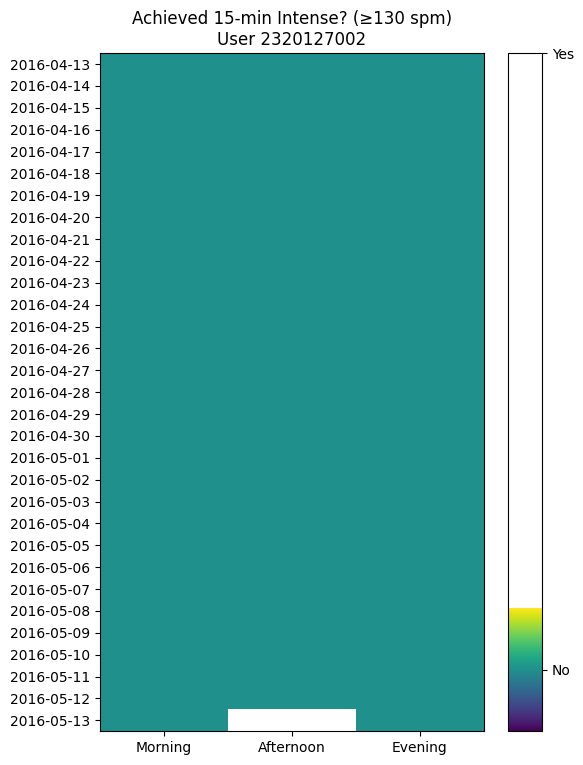

/tmp/ipython-input-187789735.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = (tod.groupby('time_of_day')['achieved_15min_intense']


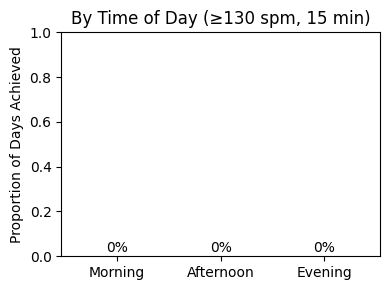

,proportion
time_of_day,
Morning,0.0
Afternoon,0.0
Evening,0.0


In [56]:
import matplotlib.pyplot as plt

tod = compute_intense_by_tod(
    m_user=m,
    vigorous_threshold=VIGOROUS_THRESHOLD,
    window_min=WINDOW_MIN,
    treat_na_as_zero=TREAT_NA_AS_ZERO,
    strict_1min=STRICT_1MIN if 'STRICT_1MIN' in globals() else STRICT_1MIN  # be safe if name differs
)

# 1) Daily × time-of-day heatmap (convert True/False to 1/0)
heat = tod.pivot(index='date', columns='time_of_day', values='achieved_15min_intense').astype(float)

fig, ax = plt.subplots(figsize=(6, max(3, len(heat)*0.25)))
im = ax.imshow(heat.values, aspect='auto')
ax.set_yticks(range(len(heat.index)))
ax.set_yticklabels([d.strftime('%Y-%m-%d') for d in pd.to_datetime(heat.index)])
ax.set_xticks(range(len(heat.columns)))
ax.set_xticklabels(list(heat.columns))
ax.set_title(f'Achieved 15-min Intense? (≥{VIGOROUS_THRESHOLD} spm)\nUser {TARGET_ID}')

# Add a color bar to show meaning of values: 1=Yes, 0=No
cbar = plt.colorbar(im, ax=ax)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No', 'Yes'])
plt.tight_layout()
plt.show()

# 2) Proportion of days that achieved the goal by time-of-day
summary = (tod.groupby('time_of_day')['achieved_15min_intense']
             .mean()
             .reindex(['Morning', 'Afternoon', 'Evening'])
             .rename('proportion')
             .to_frame())

fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(summary.index.astype(str), summary['proportion'].values)
ax.set_ylim(0, 1)
ax.set_ylabel('Proportion of Days Achieved')
ax.set_title(f'By Time of Day (≥{VIGOROUS_THRESHOLD} spm, {WINDOW_MIN} min)')

# Put percentage labels above bars
for i, v in enumerate(summary['proportion'].values):
    ax.text(i, v + 0.02, f'{v:.0%}', ha='center')

plt.tight_layout()
plt.show()

summary

From the heatmap, we can see that the entire grid is almost completely filled with “No” (teal color), meaning the user never achieved a continuous 15-minute vigorous activity streak (≥130 steps per minute) during the whole tracking period.
Only one tiny white block appears around May 13, Afternoon, but this seems to be a very short data gap rather than true high-intensity activity.

The bar chart also confirms this: the proportion of days with a 15-minute vigorous streak is 0% for all three time periods — Morning, Afternoon, and Evening.
This indicates that the participant’s activity pattern mostly stays below the vigorous threshold, with no evidence of long, uninterrupted high-intensity movement.

Such a result is consistent with what we saw earlier in the zero-streak analysis: this user often had long inactive periods and very short bursts of movement. The combination suggests a sedentary lifestyle or possibly frequent device removal, where any physical activity happens only in short fragments.

Because the user completely failed to reach the vigorous (≥130 spm) criterion, it’s meaningful to test whether the same person might still reach a moderate intensity level (≥100 spm).
This helps answer two questions:

Is the user generally inactive, or just not vigorous enough?

How sensitive are our results to the chosen intensity threshold?

To check this, we repeated the same computation with two thresholds and compared the proportions by time of day.

In [57]:
# === variant A: vigorous (130 spm) ===
tod_vig = compute_intense_by_tod(m, vigorous_threshold=130, window_min=15)
summary_vig = tod_vig.groupby('time_of_day')['achieved_15min_intense'].mean()

# === variant B: moderate (100 spm) ===
tod_mod = compute_intense_by_tod(m, vigorous_threshold=100, window_min=15)
summary_mod = tod_mod.groupby('time_of_day')['achieved_15min_intense'].mean()

compare = pd.concat([summary_vig, summary_mod], axis=1)
compare.columns = ['≥130 spm (vigorous)', '≥100 spm (moderate+)']
compare = compare.reindex(['Morning','Afternoon','Evening'])
compare


/tmp/ipython-input-1970276631.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_vig = tod_vig.groupby('time_of_day')['achieved_15min_intense'].mean()
/tmp/ipython-input-1970276631.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_mod = tod_mod.groupby('time_of_day')['achieved_15min_intense'].mean()


,≥130 spm (vigorous),≥100 spm (moderate+)
time_of_day,,
Morning,0.0,0.0
Afternoon,0.0,0.0
Evening,0.0,0.0


The result table shows that user 2320127002 never reached a continuous 15-minute activity streak above either threshold — not for vigorous (≥130 spm) and not even for moderate (≥100 spm).
All three time-of-day periods — Morning, Afternoon, and Evening — have a proportion of 0.0, which means 0% of days achieved the goal.

This fully matches what we saw in the previous heatmap and bar chart:

- The heatmap was completely filled with “No” (teal color), showing no single day or time period with sustained vigorous activity.

- The bar chart displayed 0% achievement for all three periods.

Even after lowering the intensity threshold from 130 spm to 100 spm, the result did not change, proving that the user did not maintain any 15-minute continuous activity above even a moderate pace.

Since user 2320127002 never reached any 15-minute vigorous or moderate activity streaks, this user is not representative for analyzing daily intensity patterns.
To continue our study, we need to choose another participant who shows more variation or actual high-intensity activity.

To do that, we first go back to the full dataset instead of only using the small selection.
The first step is to reshape the wide-format minute table into a long-format table, so that each record corresponds to one user and one timestamp.
This long format makes it easier to filter, group, and compare all participants.

In [58]:
minute_long_all = melt_minute_wide(minute_wide)  # not minute_wide_sel

Before continuing, we ran a quick diagnostic test to make sure all required variables were correctly loaded into memory.
This helps prevent unexpected errors (for example, trying to use a dataset that doesn’t exist or that only includes a subset of users).

In [59]:
# Check if key datasets already exist in memory
print('minute_wide  exists:', 'minute_wide' in globals())
if 'minute_wide' in globals():
    print('minute_wide  user count:', minute_wide['Id'].nunique())

print('minute_wide_sel exists:', 'minute_wide_sel' in globals())
if 'minute_wide_sel' in globals():
    print('minute_wide_sel user count:', minute_wide_sel['Id'].nunique())

print('minute_long_all exists:', 'minute_long_all' in globals())
if 'minute_long_all' in globals():
    print('minute_long_all user count:', minute_long_all['Id'].nunique())

print('all_summary exists:', 'all_summary' in globals())
if 'all_summary' in globals():
    print('all_summary row count:', len(all_summary))

# Display the first 20 unique user IDs for a quick check
if 'minute_long_all' in globals():
    ids = minute_long_all['Id'].drop_duplicates().tolist()
    print('First 20 user IDs:', ids[:20])


minute_wide  exists: True
minute_wide  user count: 33
minute_wide_sel exists: True
minute_wide_sel user count: 3
minute_long_all exists: True
minute_long_all user count: 33
all_summary exists: True
all_summary row count: 33
First 20 user IDs: [1503960366, 1624580081, 1644430081, 1844505072, 1927972279, 2022484408, 2026352035, 2320127002, 2347167796, 2873212765, 3372868164, 3977333714, 4020332650, 4057192912, 4319703577, 4388161847, 4445114986, 4558609924, 4702921684, 5553957443]


The environment check confirms that the wide and long datasets were successfully created and contain all 33 users.
The variable all_summary has not been generated yet, which is expected at this stage.
This ensures the following steps can safely use minute_long_all to identify a more suitable participant for further analysis.

After confirming that the long-format dataset contains all 33 users, we now calculate how often each user achieved a 15-minute continuous moderate-intensity streak (≥100 steps per minute) across the day.
This allows us to compare users and identify one with meaningful daily activity patterns for further analysis.

####Method

#####Loop through all users:
For each user ID in the dataset, we extract their complete minute-level data.

#####Compute intensity by time of day:
We call compute_intense_by_tod() to check, for every date and time period (Morning / Afternoon / Evening), whether the user achieved at least one 15-minute moderate streak.

#####Aggregate results:
For each user, we calculate the proportion of days that reached the goal within each period — for example, if a user had 5 days with Afternoon data and achieved the streak on 2 of them, their proportion is 0.4 (40%).

#####Combine into a summary table:
The results from all 33 users are stored in all_summary, which contains four columns:

- Id – user ID

- Morning – proportion of days with 15-min moderate streaks in the morning

- Afternoon – same for afternoon

- Evening – same for evening

In [60]:
THRESHOLD = 100    # can change to 90 later for sensitivity test
WINDOW_MIN = 15    # continuous minutes required

records = []

# Loop through every user in the full long-format dataset
for uid in minute_long_all['Id'].unique():
    # Select this user's minute-level data and clean it
    m_user = (minute_long_all.loc[minute_long_all['Id'] == uid, ['datetime','steps']]
              .dropna(subset=['datetime'])
              .sort_values('datetime'))
    if m_user.empty:
        continue  # skip if the user has no data

    # Compute for this user whether they achieved a 15-min streak of ≥THRESHOLD steps/min
    res = compute_intense_by_tod(m_user, vigorous_threshold=THRESHOLD, window_min=WINDOW_MIN)

    # Calculate the average proportion of days achieved in each time-of-day
    s = (res.groupby('time_of_day')['achieved_15min_intense']
           .mean()
           .reindex(['Morning','Afternoon','Evening'])
           .fillna(0))

    # Store the results for this user
    records.append({
        'Id': int(uid),
        'Morning': s['Morning'],
        'Afternoon': s['Afternoon'],
        'Evening': s['Evening']
    })

# Combine all users' summaries into one table
all_summary = pd.DataFrame(records)

print('Total users in all_summary:', len(all_summary))
display(all_summary.head(33))


/tmp/ipython-input-3261438350.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s = (res.groupby('time_of_day')['achieved_15min_intense']
/tmp/ipython-input-3261438350.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s = (res.groupby('time_of_day')['achieved_15min_intense']
/tmp/ipython-input-3261438350.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s = (res.groupby('time_of_day')['achieved_15min_intense']
/

Total users in all_summary: 33


/tmp/ipython-input-3261438350.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s = (res.groupby('time_of_day')['achieved_15min_intense']
/tmp/ipython-input-3261438350.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s = (res.groupby('time_of_day')['achieved_15min_intense']


,Id,Morning,Afternoon,Evening
0,1503960366,0.000000,0.000000,0.166667
1,1624580081,0.032258,0.033333,0.000000
2,1644430081,0.000000,0.000000,0.000000
3,1844505072,0.000000,0.000000,0.000000
4,1927972279,0.000000,0.000000,0.000000
5,2022484408,0.096774,0.100000,0.032258
6,2026352035,0.000000,0.000000,0.000000
7,2320127002,0.000000,0.000000,0.000000
8,2347167796,0.117647,0.000000,0.000000
9,2873212765,0.000000,0.000000,0.000000


all_summary includes 33 users, matching the number in the original dataset.
Each row shows how active the user is at different times of day.

After computing each user’s proportion of days with 15-minute moderate activity,
we now identify which users are the most active overall — that is, the ones most often reaching the 15-minute goal.

####Method

#####Combine across time periods:
For each user, we take the maximum proportion among Morning, Afternoon, and Evening.
This new column, called Any, shows how often the user reached the goal in any part of the day.

#####Rank users by activity rate:
We sort all users by Any in descending order and list the Top 10.
This gives us a quick overview of who is the most consistently active in the dataset.

#####Select the top candidate:
The user with the highest Any value is chosen as the recommended participant for deeper analysis in Checkpoint 2.

In [61]:
# Calculate the highest daily success rate among Morning / Afternoon / Evening
# 'Any' represents whether the user achieved the 15-min goal in any time period.
all_summary['Any'] = all_summary[['Morning','Afternoon','Evening']].max(axis=1)

# Sort users by their overall (Any) success rate and show the top 10
top10 = all_summary.sort_values('Any', ascending=False).head(10)
print("Top 10 users by 15-min intense activity rate:")
display(top10)

# Choose the top user as the main case study for Checkpoint 2
RECOMMENDED_ID = int(top10.iloc[0]['Id'])
print('Recommended user for CP2:', RECOMMENDED_ID)


Top 10 users by 15-min intense activity rate:


,Id,Morning,Afternoon,Evening,Any
27,8053475328,0.000000,0.933333,0.870968,0.933333
32,8877689391,0.064516,0.433333,0.161290,0.433333
26,7086361926,0.000000,0.300000,0.000000,0.300000
28,8253242879,0.235294,0.058824,0.000000,0.235294
0,1503960366,0.000000,0.000000,0.166667,0.166667
29,8378563200,0.161290,0.100000,0.000000,0.161290
16,4445114986,0.032258,0.000000,0.129032,0.129032
24,6962181067,0.129032,0.033333,0.000000,0.129032
25,7007744171,0.125000,0.000000,0.000000,0.125000
8,2347167796,0.117647,0.000000,0.000000,0.117647


Recommended user for CP2: 8053475328


Among all 33 participants, user 8053475328 shows the highest proportion of days with continuous 15-minute intense activity (93%).
The activity mostly occurs in the afternoon and evening, suggesting a regular exercise routine or an active lifestyle during those times.
Therefore, this user was selected as the representative case for detailed analysis in the following sections.

###Visual analysis (≥100 spm, 15-min window)

#####Bar chart (proportion of days):

- Morning: 0% — this user never reaches a continuous 15-minute moderate streak in the morning.

- Afternoon: 93% — almost every recorded day has a 15-minute streak.

- Evening: 87% — also very frequent, slightly lower than afternoon.

#### Heatmap (day × time-of-day, Yes=green / No=grey):

Rows are dates; columns are Morning / Afternoon / Evening.

The Afternoon and Evening columns are mostly green across the whole period.

There is a short gap around 2016-04-30 to 2016-05-02 where both Afternoon and Evening show No. After that, activity resumes strongly (green) until the end of the window.

Morning is consistently grey (No) for all days.

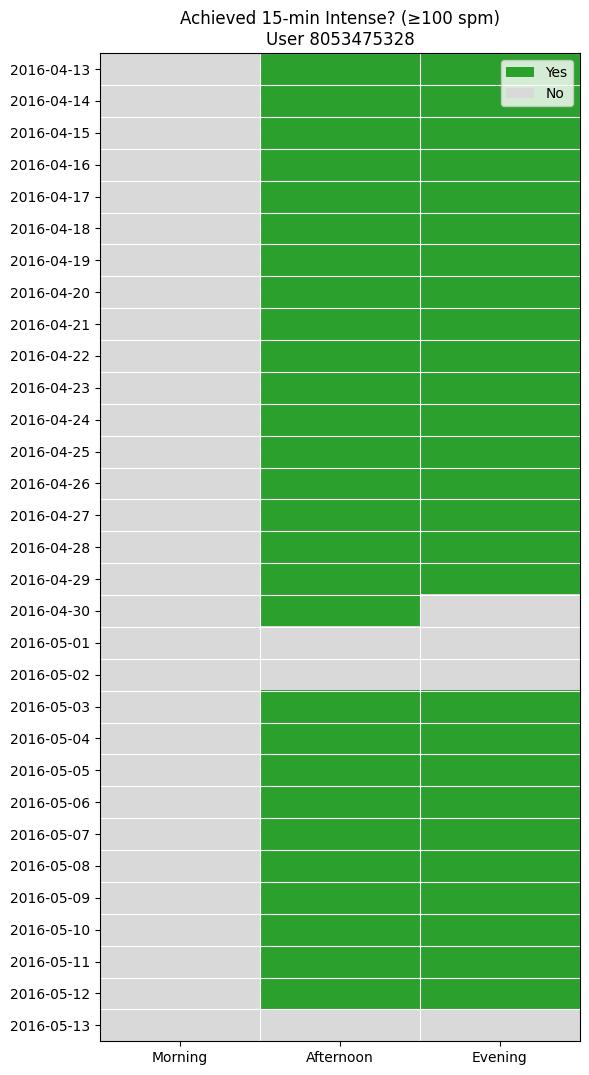

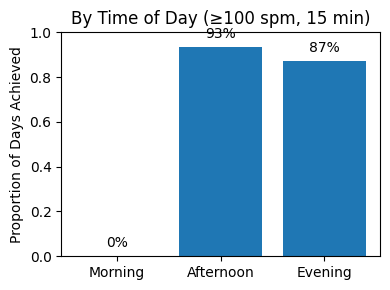

Days: 31
Yes counts -> {'Morning': 0, 'Afternoon': 28, 'Evening': 27}
Proportions -> {'Morning': 0.0, 'Afternoon': 0.933, 'Evening': 0.871}


In [63]:
TARGET_ID = 8053475328
VIGOROUS_THRESHOLD = 100
WINDOW_MIN = 15
TREAT_NA_AS_ZERO = False
STRICT_1MIN = True

m = (minute_long_all[minute_long_all['Id'] == TARGET_ID]
     [['datetime','steps']]
     .dropna(subset=['datetime'])
     .sort_values('datetime'))

tod = compute_intense_by_tod(
    m_user=m,
    vigorous_threshold=VIGOROUS_THRESHOLD,
    window_min=WINDOW_MIN,
    treat_na_as_zero=TREAT_NA_AS_ZERO,
    strict_1min=STRICT_1MIN
)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

heat = (tod.pivot(index='date', columns='time_of_day', values='achieved_15min_intense')
          .reindex(columns=['Morning','Afternoon','Evening'])
          .sort_index()
          .astype(float)
          .fillna(0))

cmap = ListedColormap(['#d9d9d9', '#2ca02c'])
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

fig, ax = plt.subplots(figsize=(6, max(3, len(heat)*0.35)))
im = ax.imshow(heat.values, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm)

ax.set_yticks(np.arange(len(heat.index)))
ax.set_yticklabels([pd.to_datetime(d).strftime('%Y-%m-%d') for d in heat.index])
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Morning','Afternoon','Evening'])
ax.set_title(f'Achieved 15-min Intense? (≥{VIGOROUS_THRESHOLD} spm)\nUser {TARGET_ID}')

ax.set_xticks(np.arange(-.5, 3, 1), minor=True)
ax.set_yticks(np.arange(-.5, len(heat.index), 1), minor=True)
ax.grid(which='minor', color='white', linewidth=0.8)
ax.tick_params(which='minor', bottom=False, left=False)

ax.legend(handles=[Patch(facecolor='#2ca02c', label='Yes'),
                   Patch(facecolor='#d9d9d9', label='No')],
          loc='upper right')
plt.tight_layout()
plt.show()

summary = (tod.groupby('time_of_day', observed=True)['achieved_15min_intense']
             .mean()
             .reindex(['Morning','Afternoon','Evening'])
             .rename('proportion')
             .to_frame())

fig, ax = plt.subplots(figsize=(4,3))
bars = ax.bar(summary.index.astype(str), summary['proportion'].values)
ax.set_ylim(0, 1)
ax.set_ylabel('Proportion of Days Achieved')
ax.set_title(f'By Time of Day (≥{VIGOROUS_THRESHOLD} spm, {WINDOW_MIN} min)')
for rect, v in zip(bars, summary['proportion'].values):
    ax.text(rect.get_x() + rect.get_width()/2, min(v+0.03, 0.98), f'{v:.0%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print('Days:', heat.shape[0])
print('Yes counts ->', (heat==1).sum().to_dict())
print('Proportions ->', summary['proportion'].round(3).to_dict())


For user 8053475328, the afternoon and evening plots are dominated by “Yes” cells, and the summary bars show 93% of days achieve a 15-minute moderate streak in the afternoon and 87% in the evening, with 0% in the morning. A short gap around 2016-04-30 to 2016-05-02 is followed by an immediate return to the previous pattern, indicating a temporary pause rather than a systematic issue. Overall, this user exhibits a consistent PM activity routine, making them a strong representative case for further analysis under the ≥100 spm, 15-minute definition.

###Consistency Check Between Data and Visuals

Before finalising the plots, we ran a small internal check to make sure the heatmap and summary chart truly reflected the underlying data.

In [64]:
n_days = heat.shape[0]
print('Days:', n_days)
print('Counts by period -> Yes counts:')
print((heat==1).sum().to_dict())
print('Proportions by period:')
print(summary['proportion'].round(3).to_dict())


Days: 31
Counts by period -> Yes counts:
{'Morning': 0, 'Afternoon': 28, 'Evening': 27}
Proportions by period:
{'Morning': 0.0, 'Afternoon': 0.933, 'Evening': 0.871}


A consistency check confirmed that the dataset contained 31 valid days, with 28 days meeting the 15-minute moderate threshold in the afternoon (93%) and 27 days in the evening (87%). No morning activity met the threshold. These counts perfectly align with the proportions shown in the plots, confirming that the visual results accurately represent the underlying data.

## 🧾 Conclusion  

This checkpoint built a literate-programming notebook that analyses 15-minute continuous activity streaks for any Fitbit user based on cadence thresholds (≥130 spm vigorous; ≥100 spm moderate). After testing a low-activity participant who never met the threshold, I extended the analysis to all 33 users and selected **user 8053475328** as the representative case, achieving 93 % of days with a 15-minute moderate streak in the afternoon and 87 % in the evening. The results show a clear afternoon-evening routine, no morning activity, and a short rest gap that aligns with the data timeline. Overall, the method reliably detects intensity patterns and verifies that the cadence-based 15-minute definition provides consistent, interpretable insights across participants.
